## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 1. Exploratory Data Analysis </span>

In [1]:
import pandas as pd

polusa_balanced_2017_1 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2017_1.csv', header = 0)
polusa_balanced_2017_2 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2017_2.csv', header = 0)

polusa_balanced_2018_1 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2018_1.csv', header = 0)
polusa_balanced_2018_2 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2018_2.csv', header = 0)

polusa_balanced_2019_1 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2019_1.csv', header = 0)
polusa_balanced_2019_2 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2019_2.csv', header = 0)

In [2]:
polusa_unbalanced_2017_1 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_unbalanced/2017_1.csv', header = 0)
polusa_unbalanced_2017_2 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_unbalanced/2017_2.csv', header = 0)

polusa_unbalanced_2018_1 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_unbalanced/2018_1.csv', header = 0)
polusa_unbalanced_2018_2 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_unbalanced/2018_2.csv', header = 0)

polusa_unbalanced_2019_1 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_unbalanced/2019_1.csv', header = 0)
polusa_unbalanced_2019_2 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_unbalanced/2019_2.csv', header = 0)

In [3]:
polusa_balanced = pd.concat([polusa_balanced_2017_1, polusa_balanced_2017_2, polusa_balanced_2018_1, polusa_balanced_2018_2, polusa_balanced_2019_1, polusa_balanced_2019_2], axis = 0)
polusa_balanced.head()

,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning
0,55171935,2017-01-01 00:00:00,Los Angeles Times,Afghan refugees coming to California struggle ...,NaN,California's capital has emerged as a leading ...,Associated Press,www.latimes.com,http://www.latimes.com/local/lanow/la-me-ln-af...,LEFT
1,55208434,2017-01-01 00:00:00,NBC News,Minimum Wages Will Rise in Nearly Two Dozen St...,"Twenty-two states, plus the District of Columb...",Play Facebook\nTwitter\nGoogle Plus\nEmbed Tru...,Emma Margolin,www.nbcnews.com,http://www.nbcnews.com/news/us-news/minimum-wa...,CENTER
2,55172357,2017-01-01 00:00:00,Los Angeles Times,Fire engulfs Long Beach apartment unit; man fo...,NaN,A man was found dead as a fire engulfed an apa...,Rong-Gong Lin Ii,www.latimes.com,http://www.latimes.com/local/lanow/la-me-ln-lo...,LEFT
3,115892789,2017-01-01 00:00:00,ABC News,Obama Boosted White House Technology; Trump Se...,Obama Boosted White House Technology; Trump Se...,As Barack Obama began preparing to leave offic...,Abc News,abcnews.go.com,http://abcnews.go.com/Technology/wireStory/oba...,CENTER
4,4375253,2017-01-01 00:00:00,Fox News,Most residents evacuated by sinkhole could ret...,The new public works commissioner in a suburba...,The new public works commissioner in a suburba...,NaN,www.foxnews.com,http://www.foxnews.com/us/2017/01/01/most-resi...,RIGHT


In [4]:
polusa_unbalanced = pd.concat([polusa_unbalanced_2017_1, polusa_unbalanced_2017_2, polusa_unbalanced_2018_1, polusa_unbalanced_2018_2, polusa_unbalanced_2019_1, polusa_unbalanced_2019_2], axis = 0)
polusa_unbalanced.head()

,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning
0,115898626,2017-01-01 00:00:00,ABC News,"3 Men Decapitated, 2 More Slain in Acapulco Ov...","3 Men Decapitated, 2 More Slain in Acapulco Ov...",At least five people were killed over the New ...,Abc News,abcnews.go.com,http://abcnews.go.com/International/wireStory/...,CENTER
1,115884354,2017-01-01 00:00:00,ABC News,Thousands in Hong Kong March for Pro-Democracy...,Thousands in Hong Kong March for Pro-Democracy...,"Nearly 5,000 people in Hong Kong marched in a ...",Abc News,abcnews.go.com,http://abcnews.go.com/International/wireStory/...,CENTER
2,115880292,2017-01-01 00:00:00,ABC News,Slovakia Bans Train Patrols by Far-Right Party,Slovakia Bans Train Patrols by Far-Right Party,Train and railway station patrols set up by a ...,Abc News,abcnews.go.com,http://abcnews.go.com/International/wireStory/...,CENTER
3,115985210,2017-01-01 00:00:00,ABC News,Suicide Bombers Kill 9 South of Iraq's Capital,Suicide Bombers Kill 9 South of Iraq's Capital,Iraqi officials say a pair of suicide bombers ...,Abc News,abcnews.go.com,http://abcnews.go.com/International/wireStory/...,CENTER
4,115912220,2017-01-01 00:00:00,ABC News,Officials: Delaware Man Injured in Istanbul Ni...,Officials: Delaware Man Injured in Istanbul Ni...,The State Department has confirmed that a Dela...,Abc News,abcnews.go.com,http://abcnews.go.com/US/wireStory/officials-d...,CENTER


### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 1.1. Key Features to Use </span>

- Check for null values.

In [5]:
polusa_balanced.isna().sum()

id                        0
date_publish              0
outlet                    0
headline                 26
lead                  64944
body                      0
authors              172938
domain                    0
url                       0
political_leaning         0
dtype: int64

In [6]:
polusa_unbalanced.isna().sum()

id                        0
date_publish              0
outlet                    0
headline                 26
lead                  78554
body                      0
authors              217912
domain                    0
url                       0
political_leaning         0
dtype: int64

- Since only 26 rows are missing headlines in both datasets, we should drop them.
- Drop the lead column because summarizing the body captures essential information more effectively, making it redundant.
- Drop the authors column since it won’t be used in the recommendation pipeline.

In [7]:
# Drop rows with missing headlines
polusa_balanced = polusa_balanced.dropna(subset = ["headline"])
polusa_unbalanced = polusa_unbalanced.dropna(subset = ["headline"])

# Drop irrelevant columns
polusa_balanced = polusa_balanced.drop(columns = ["lead", "authors"])
polusa_unbalanced = polusa_unbalanced.drop(columns = ["lead", "authors"])

- For POLUSA-Unbalanced (Bias Analysis): Remove `UNDEFINED` political leaning tag to ensure only well-classified political content is used for exploring bias, and training the biased recommendation model.
- For POLUSA-Balanced (Training Data): Remove `UNDEFINED` political leaning tag to ensure only well-classified political content is used for training, maintaining balanced political representation in recommendations.

In [8]:
polusa_balanced = polusa_balanced[polusa_balanced['political_leaning'] != 'UNDEFINED'].reset_index(drop = True)
polusa_unbalanced = polusa_unbalanced[polusa_unbalanced['political_leaning'] != 'UNDEFINED'].reset_index(drop = True)

In [9]:
polusa_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668333 entries, 0 to 668332
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 668333 non-null  int64 
 1   date_publish       668333 non-null  object
 2   outlet             668333 non-null  object
 3   headline           668333 non-null  object
 4   body               668333 non-null  object
 5   domain             668333 non-null  object
 6   url                668333 non-null  object
 7   political_leaning  668333 non-null  object
dtypes: int64(1), object(7)
memory usage: 40.8+ MB


In [10]:
polusa_unbalanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206106 entries, 0 to 1206105
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   id                 1206106 non-null  int64 
 1   date_publish       1206106 non-null  object
 2   outlet             1206106 non-null  object
 3   headline           1206106 non-null  object
 4   body               1206106 non-null  object
 5   domain             1206106 non-null  object
 6   url                1206106 non-null  object
 7   political_leaning  1206106 non-null  object
dtypes: int64(1), object(7)
memory usage: 73.6+ MB


### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 1.2. Bias Analysis with POLUSA Unbalanced </span>

- No need for stratified balancing: The goal is to analyze natural biases.
- Summarize the body + combine it with the headline: Helps improve content representation for CBF.
- Text cleaning should be applied to headlines: Ensures consistency when analyzing bias in framing.

#### <span style="font-family: Latin Modern Roman; font-size: 21px;"> 1.2.1 Body Summarizing </span>

Need to summarize the body or the articles as it is very long:
- Reduce Noise: The original text often contains irrelevant or repetitive information. Summarization extracts key points, removing unnecessary content.
- Improve Efficiency: Shorter text makes the recommender system faster and more accurate.
- Better Similarity Calculation: Summaries help the model focus on core ideas, enhancing content-based recommendation quality.

In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

# Define sumy summarization function
def summarize_text(text, num_sentences = 3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return ' '.join([str(sentence) for sentence in summary])

# Define summarization function
def summarize_row(text):
    return summarize_text(text, num_sentences = 3)

In [ ]:
from joblib import Parallel, delayed

# Set number of cores
num_cores = 8

# Apply parallel processing
results = Parallel(n_jobs = num_cores, backend = "loky")(delayed(summarize_row)(text) for text in polusa_unbalanced["body"])
polusa_unbalanced["body_summary"] = results
polusa_unbalanced["text"] = polusa_unbalanced["headline"] + " " + polusa_unbalanced["body_summary"]

#### <span style="font-family: Latin Modern Roman; font-size: 21px;"> 1.2.2 Text Cleaning </span>

- Remove extra whitespaces: Remove leading, trailing, and extra spaces.
- Remove Special Characters: Eliminate non-alphanumeric characters (e.g., !@#$%) as they add noise.
- Convert to Lowercase: Standardize text for better token matching.
- Remove Stopwords: Remove common words (e.g., "the", "is") that don’t add significant meaning.
- Lemmatization: Reduce words to their base form (e.g., "running" → "run").

In [13]:
import re
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Define the text cleaning function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Remove special characters
    text = re.sub(r'\W', ' ', str(text))  

    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove not alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization
    tokens = word_tokenize(text)
    # Lemmatization and stop words removal
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 3]
    
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergiocuencanunez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sergiocuencanunez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sergiocuencanunez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
# Apply parallel processing for text cleaning
tokens_results = Parallel(n_jobs = num_cores, backend = "loky")(
    delayed(clean_text)(text) for text in polusa_unbalanced["text"]
)

polusa_unbalanced["tokens"] = tokens_results
polusa_unbalanced["text_cleaned"] = [" ".join(tokens) for tokens in tokens_results]

In [20]:
polusa_unbalanced.to_csv("../data/polusa_unbalanced.csv", index = False)

#### <span style="font-family: Latin Modern Roman; font-size: 21px;"> 1.2.3 Bias Patterns and Discovery</span>

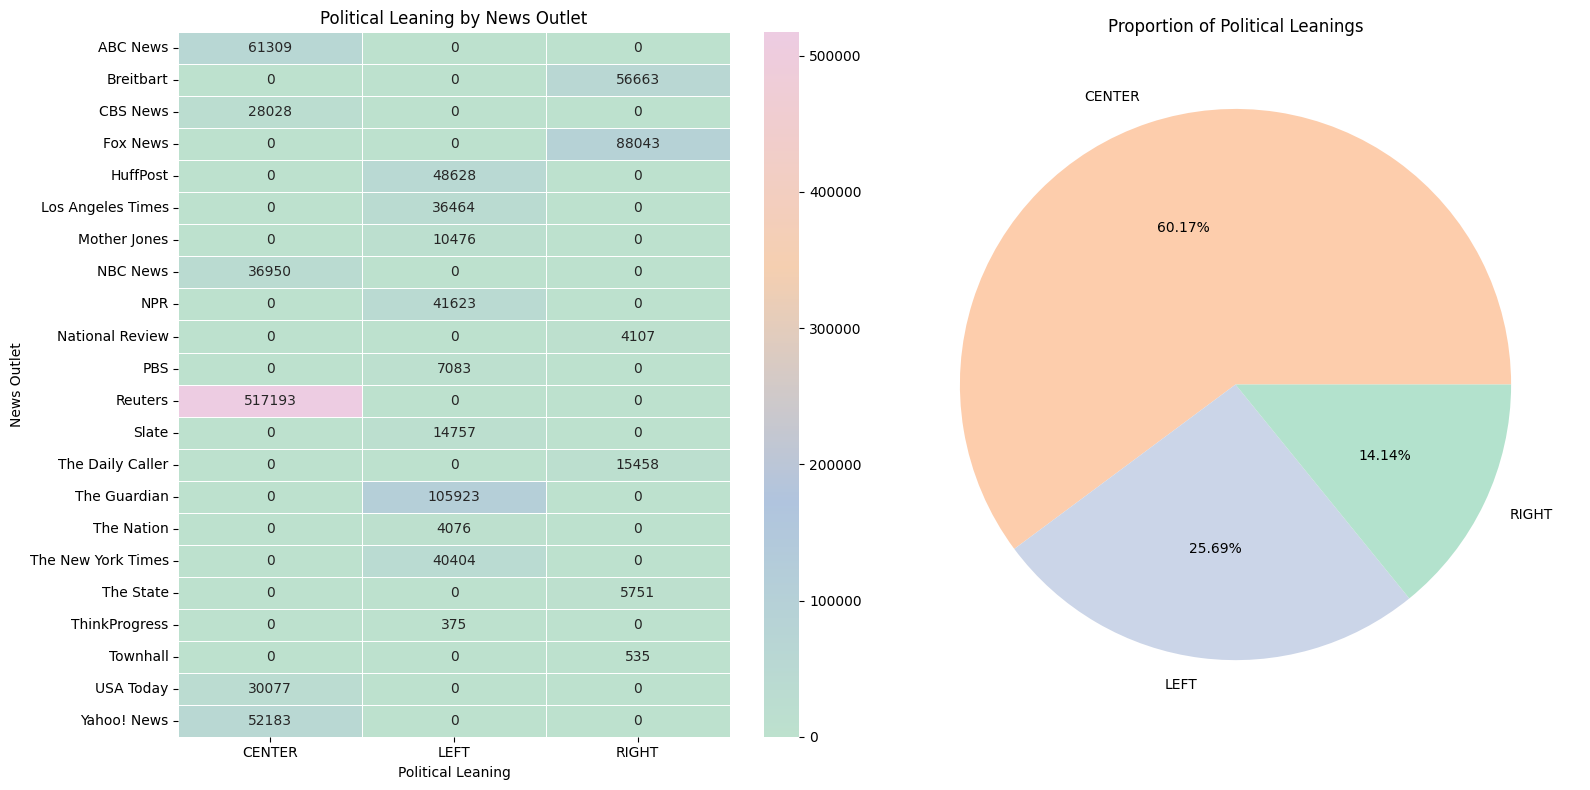

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

pastel_palette = sns.blend_palette(["#BDE1CE", "#B0C4DE", "#F5CFB0", "#EDCCE2"], as_cmap = True)
pastel2_colors = sns.color_palette("Pastel2")[:4]
political_color_map_pastel2 = {
    "RIGHT": pastel2_colors[0],
    "CENTER": pastel2_colors[1],
    "LEFT": pastel2_colors[2],
}

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Political Leaning by News Outlet
outlet_political_distribution = polusa_unbalanced.groupby(["outlet", "political_leaning"]).size().unstack(fill_value = 0)
sns.heatmap(outlet_political_distribution, cmap = pastel_palette, annot = True, fmt = "d", linewidths = 0.5, ax = axes[0])
axes[0].set_title("Political Leaning by News Outlet")
axes[0].set_xlabel("Political Leaning")
axes[0].set_ylabel("News Outlet")

# Proportion of Political Leanings
political_counts = polusa_unbalanced["political_leaning"].value_counts()
labels = political_counts.index
colors = [political_color_map_pastel2[label] for label in labels]
political_counts.plot(
    kind = "pie", autopct = '%1.2f%%', colors = colors, labels = labels, ax = axes[1]
)
axes[1].set_ylabel("")  # Remove 'Count' label
axes[1].set_title("Proportion of Political Leanings")

plt.tight_layout()
plt.show()


- **Selection Bias**: The dataset is skewed towards center-leaning outlets, which represent 46.17% of the total articles, compared to 19.71% (Left) and 10.85% (Right). This imbalance in source representation means that a news recommendation system trained on this dataset may naturally favor centrist perspectives over left or right perspectives.
- **Media Bias**: Certain media outlets dominate within each political leaning, reinforcing specific narratives, amplifying editorial biases, and making it harder for diverse viewpoints to surface in recommendations. Some outlets contribute disproportionately to specific leanings. For instance:
    - Reuters (Center) has an overwhelming 517,193 articles, significantly more than any other source.
    - The Guardian (Left) contributes 105,923 articles, making it one of the primary left-leaning sources.
    - Fox News (Right) is a dominant right-leaning outlet, contributing 88,043 articles, but right-leaning sources are fewer in general.
    - NBC News (Center), ABC News (Center), and BBC (Undefined) also have a strong presence, influencing the dataset's balance.

The recommendation system would inherently prefer articles from overrepresented sources (e.g., Reuters, The Guardian, Fox News) rather than equally distributing news from different ideological perspectives.

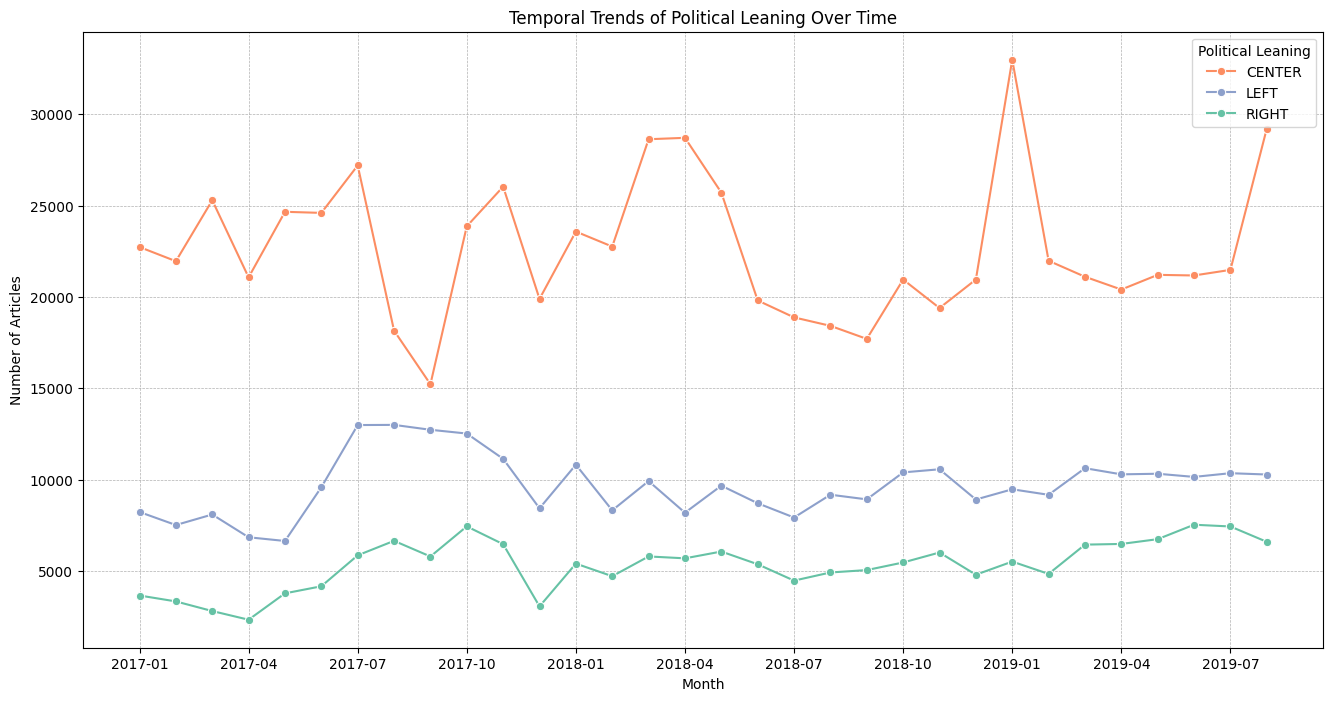

In [ ]:
polusa_unbalanced["date_publish"] = pd.to_datetime(polusa_unbalanced["date_publish"])
polusa_unbalanced["year"] = polusa_unbalanced["date_publish"].dt.year
polusa_unbalanced["year_month"] = polusa_unbalanced["date_publish"].dt.to_period("M").astype(str)

monthly_distribution = polusa_unbalanced.groupby(["year_month", "political_leaning"]).size().reset_index(name = "count")
polusa_unbalanced['year_month'] = polusa_unbalanced['date_publish'].dt.to_period('M')

set2_colors = sns.color_palette("Set2")[:4]
political_color_map_set2 = {
    "RIGHT": set2_colors[0],
    "CENTER": set2_colors[1],
    "LEFT": set2_colors[2],
}

# Temporal Trends of Political Leaning Over Time
plt.figure(figsize=(16, 8))
ax = sns.lineplot(data = monthly_distribution, x = "year_month", y = "count", hue = "political_leaning", marker="o", palette = political_color_map_set2)
x_labels = monthly_distribution["year_month"].unique()
ax.set_xticks(x_labels[::3])
ax.legend(title = "Political Leaning")
plt.ylabel("Number of Articles")
plt.xlabel("Month")
plt.title("Temporal Trends of Political Leaning Over Time")
plt.grid(True, which = "both", ls = "--", linewidth = 0.5)
plt.show()

- **Selection Bias**: If a user engages primarily with news from a period where one political leaning was dominant, the recommendation system might reinforce that preference rather than diversifying exposure.
- **Exposure Bias**: Center-leaning news had the highest article volume throughout 2017-2019, meaning users engaging with news during these years were more exposed to centrist perspectives. 2018 had a significant increase in Undefined sources, particularly mid-year, while Left decreased and Right remained the lowest. If users trained a recommendation model during this period, it might lead to a bias favoring Undefined perspectives (ignoring that Center stories were more prevalent overall).

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sergiocuencanunez/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


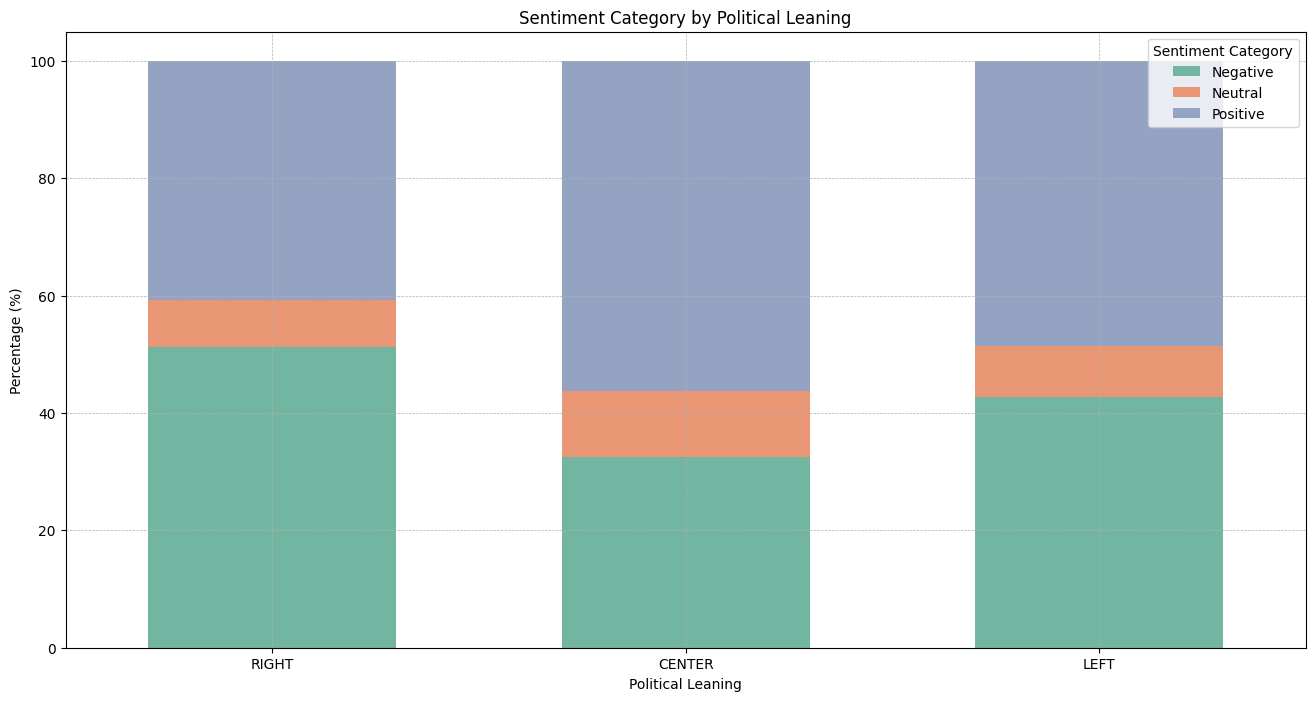

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK sentiment lexicon if not already downloaded
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Compute sentiment score
polusa_unbalanced["text_sentiment"] = polusa_unbalanced["text_cleaned"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

# Function to categorize sentiment
def categorize_sentiment(score):
    if score <= -0.2:
        return "Negative"
    elif score >= 0.2:
        return "Positive"
    else:
        return "Neutral"

# Apply categorization
polusa_unbalanced["sentiment_category"] = polusa_unbalanced["text_sentiment"].apply(categorize_sentiment)

# Compute sentiment distribution
sentiment_distribution = polusa_unbalanced.groupby(["political_leaning", "sentiment_category"]).size().unstack()
sentiment_distribution = sentiment_distribution.div(sentiment_distribution.sum(axis = 1), axis = 0) * 100
sentiment_palette = {"Negative": set2_colors[0], "Neutral": set2_colors[1], "Positive": set2_colors[2]}

# Sentiment Category by Political Leaning
plt.figure(figsize=(16, 8))

categories = ["RIGHT", "CENTER", "LEFT"]
sentiment_distribution = sentiment_distribution.reindex(categories)
bottom_values = None

for sentiment in ["Negative", "Neutral", "Positive"]:
    sns.barplot(x = sentiment_distribution.index, y = sentiment_distribution[sentiment], color = sentiment_palette[sentiment], label = sentiment, width = 0.6, bottom = bottom_values)
    bottom_values = sentiment_distribution[sentiment] if bottom_values is None else bottom_values + sentiment_distribution[sentiment]

plt.legend(title="Sentiment Category")
plt.title("Sentiment Category by Political Leaning")
plt.xlabel("Political Leaning")
plt.ylabel("Percentage (%)")
plt.grid(True, which = "both", ls = "--", linewidth = 0.5)
plt.show()

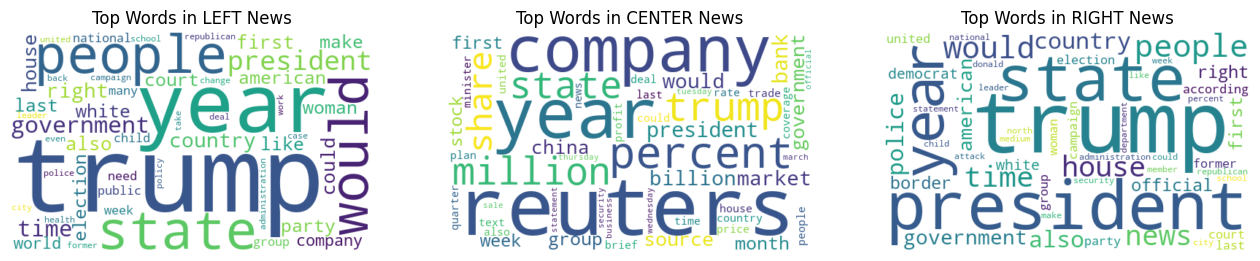

In [44]:
from collections import Counter
from wordcloud import WordCloud

leanings = ["LEFT", "CENTER", "RIGHT"]
excluded_words = {"said", "saying", "told", "says", "say", "report", "reported"}

# Top Words in News by Political Leaning
fig, axes = plt.subplots(1, 3, figsize = (16, 8))
for i, leaning in enumerate(leanings):
    text = " ".join(polusa_unbalanced[polusa_unbalanced["political_leaning"] == leaning]["text_cleaned"])
    filtered_words = [word for word in text.split() if word not in excluded_words]
    word_freq = Counter(filtered_words).most_common(50)    
    wordcloud = WordCloud(width = 500, height = 300, background_color = "white").generate_from_frequencies(dict(word_freq))    
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Top Words in {leaning} News")
plt.show()

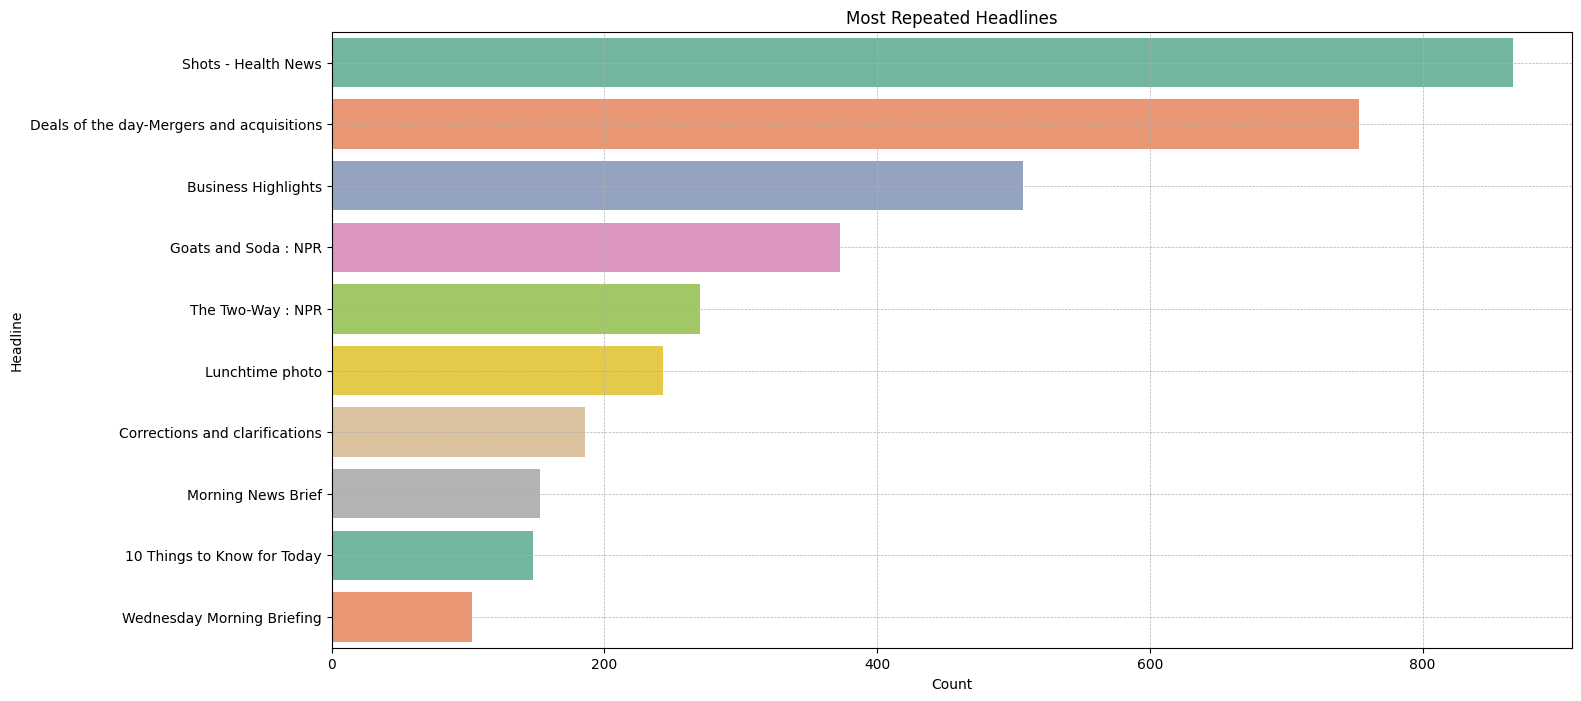

In [41]:
popular_articles = polusa_unbalanced["headline"].value_counts().nlargest(10)

plt.figure(figsize = (16, 8))
sns.barplot(x = popular_articles.values, y = popular_articles.index, hue = popular_articles.index, palette = "Set2")
plt.title("Most Repeated Headlines")
plt.xlabel("Count")
plt.ylabel("Headline")
plt.grid(True, which = "both", ls = "--", linewidth = 0.5)
plt.show()

### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 1.3. Fair Exposure with POLUSA Balanced </span>
<div style="text-align: justify;">

- Apply stratified balancing: Ensures fairness in recommendations.
- Summarize the body + combine it with the headline: Helps improve content representation for CBF.
- Text cleaning should be applied to both headline and body_summary: Ensures clean inputs for training.

</div>

#### <span style="font-family: Latin Modern Roman; font-size: 21px;"> 1.3.1 Stratified Sampling for Political Balance </span>

In [32]:
leaning_counts = polusa_balanced['political_leaning'].value_counts()
print("Articles per political leaning before sampling:\n", leaning_counts)

min_class_size = leaning_counts.min()
balanced_size = min_class_size * 3

polusa_balanced_final = pd.DataFrame()

for leaning in ["LEFT", "CENTER", "RIGHT"]:
    leaning_group = polusa_balanced[polusa_balanced["political_leaning"] == leaning]
    
    if len(leaning_group) > min_class_size:
        sampled = leaning_group.sample(n = min_class_size, random_state = 42)
    else:
        sampled = leaning_group
    
    polusa_balanced_final = pd.concat([polusa_balanced_final, sampled])

polusa_balanced_final = polusa_balanced_final.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset size:", len(polusa_balanced_final))
print("Articles per political leaning after sampling:\n", polusa_balanced_final['political_leaning'].value_counts())

Articles per political leaning before sampling:
 political_leaning
LEFT      279819
CENTER    243808
RIGHT     144706
Name: count, dtype: int64
Balanced dataset size: 434118
Articles per political leaning after sampling:
 political_leaning
LEFT      144706
RIGHT     144706
CENTER    144706
Name: count, dtype: int64


#### <span style="font-family: Latin Modern Roman; font-size: 21px;"> 1.3.2 Body Summarizing </span>

In [33]:
# Apply parallel processing
results = Parallel(n_jobs = num_cores, backend = "loky")(delayed(summarize_row)(text) for text in polusa_balanced_final["body"])
polusa_balanced_final["body_summary"] = results
polusa_balanced_final["text"] = polusa_balanced_final["headline"] + " " + polusa_balanced_final["body_summary"]

#### <span style="font-family: Latin Modern Roman; font-size: 21px;"> 1.3.3 Text Cleaning </span>

In [34]:
# Apply parallel processing for text cleaning
tokens_results = Parallel(n_jobs = num_cores, backend = "loky")(
    delayed(clean_text)(text) for text in polusa_balanced_final["text"]
)

polusa_balanced_final["tokens"] = tokens_results
polusa_balanced_final["text_cleaned"] = [" ".join(tokens) for tokens in tokens_results]

In [35]:
polusa_balanced_final.to_csv("../data/polusa_balanced.csv", index = False)

#### <span style="font-family: Latin Modern Roman; font-size: 21px;"> 1.3.4 Unbiased Check </span>

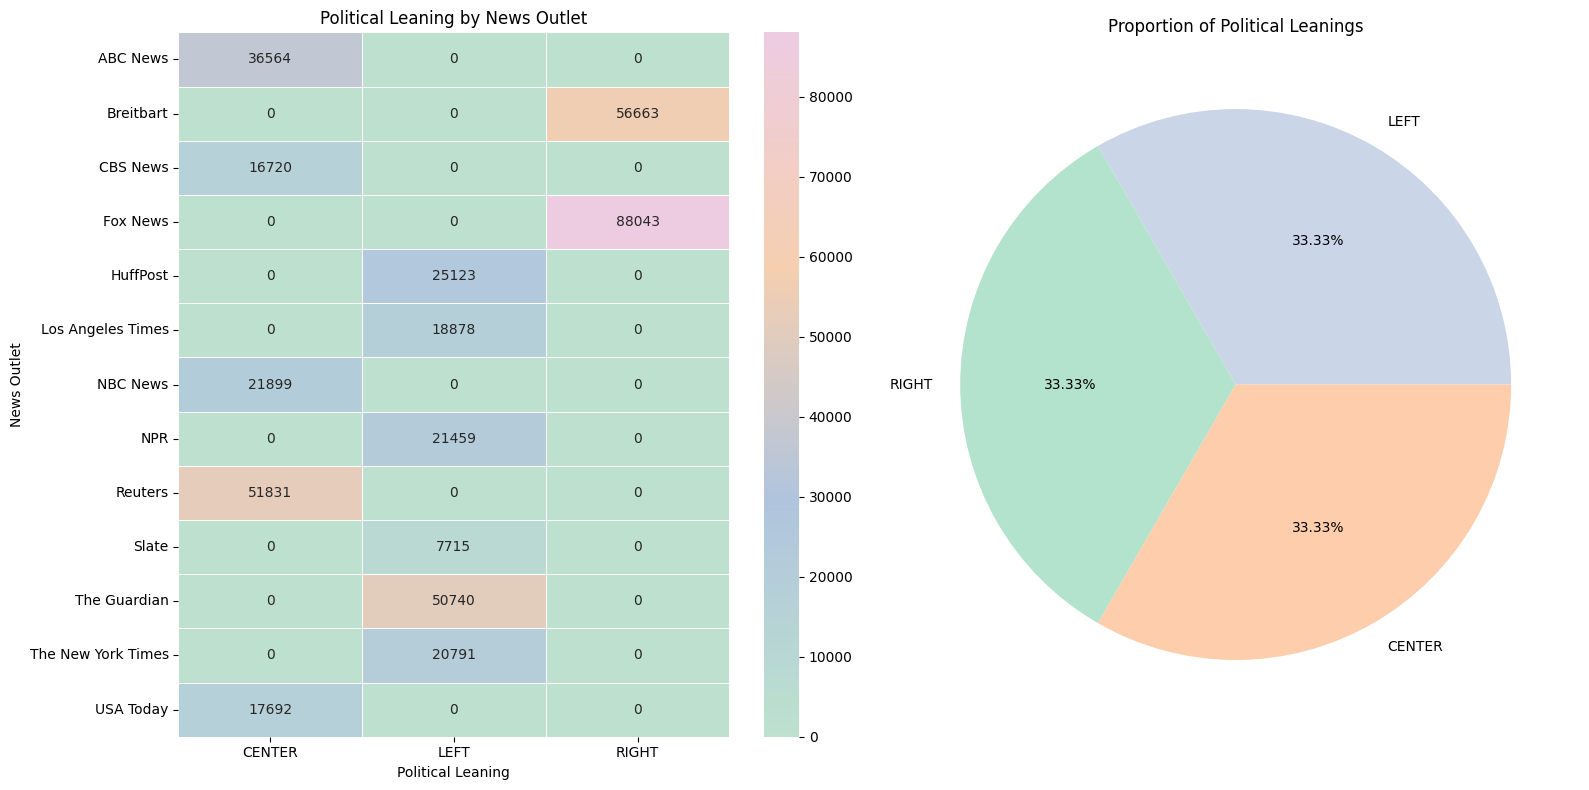

In [36]:
pastel_palette = sns.blend_palette(["#BDE1CE", "#B0C4DE", "#F5CFB0", "#EDCCE2"], as_cmap = True)
pastel2_colors = sns.color_palette("Pastel2")[:4]
political_color_map_pastel2 = {
    "RIGHT": pastel2_colors[0],
    "CENTER": pastel2_colors[1],
    "LEFT": pastel2_colors[2],
}

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Political Leaning by News Outlet
outlet_political_distribution = polusa_balanced_final.groupby(["outlet", "political_leaning"]).size().unstack(fill_value = 0)
sns.heatmap(outlet_political_distribution, cmap = pastel_palette, annot = True, fmt = "d", linewidths = 0.5, ax = axes[0])
axes[0].set_title("Political Leaning by News Outlet")
axes[0].set_xlabel("Political Leaning")
axes[0].set_ylabel("News Outlet")

# Proportion of Political Leanings
political_counts = polusa_balanced_final["political_leaning"].value_counts()
labels = political_counts.index
colors = [political_color_map_pastel2[label] for label in labels]
political_counts.plot(
    kind = "pie", autopct = '%1.2f%%', colors = colors, labels = labels, ax = axes[1]
)
axes[1].set_ylabel("")  # Remove 'Count' label
axes[1].set_title("Proportion of Political Leanings")

plt.tight_layout()
plt.show()

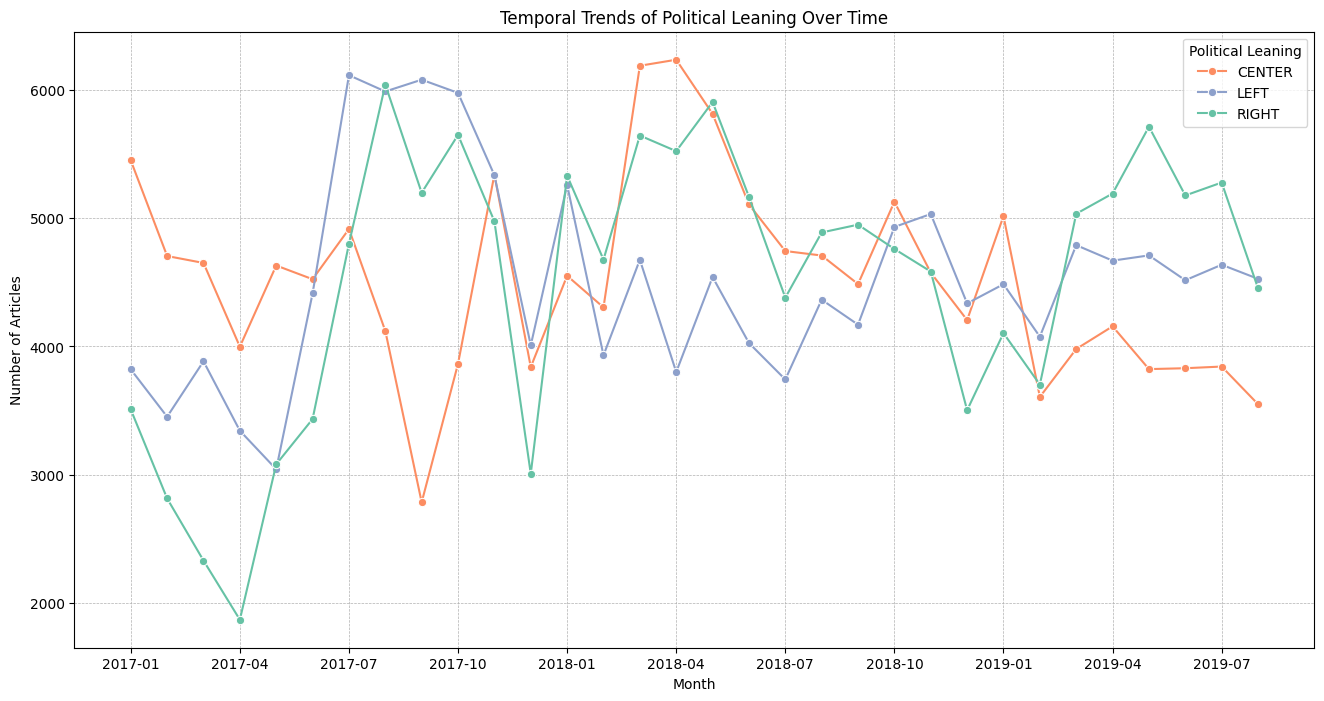

In [37]:
polusa_balanced_final["date_publish"] = pd.to_datetime(polusa_balanced_final["date_publish"])
polusa_balanced_final["year"] = polusa_balanced_final["date_publish"].dt.year
polusa_balanced_final["year_month"] = polusa_balanced_final["date_publish"].dt.to_period("M").astype(str)

monthly_distribution = polusa_balanced_final.groupby(["year_month", "political_leaning"]).size().reset_index(name = "count")
polusa_balanced_final['year_month'] = polusa_balanced_final['date_publish'].dt.to_period('M')

set2_colors = sns.color_palette("Set2")[:4]
political_color_map_set2 = {
    "RIGHT": set2_colors[0],
    "CENTER": set2_colors[1],
    "LEFT": set2_colors[2],
}

# Temporal Trends of Political Leaning Over Time
plt.figure(figsize=(16, 8))
ax = sns.lineplot(data = monthly_distribution, x = "year_month", y = "count", hue = "political_leaning", marker="o", palette = political_color_map_set2)
x_labels = monthly_distribution["year_month"].unique()
ax.set_xticks(x_labels[::3])
ax.legend(title = "Political Leaning")
plt.ylabel("Number of Articles")
plt.xlabel("Month")
plt.title("Temporal Trends of Political Leaning Over Time")
plt.grid(True, which = "both", ls = "--", linewidth = 0.5)
plt.show()

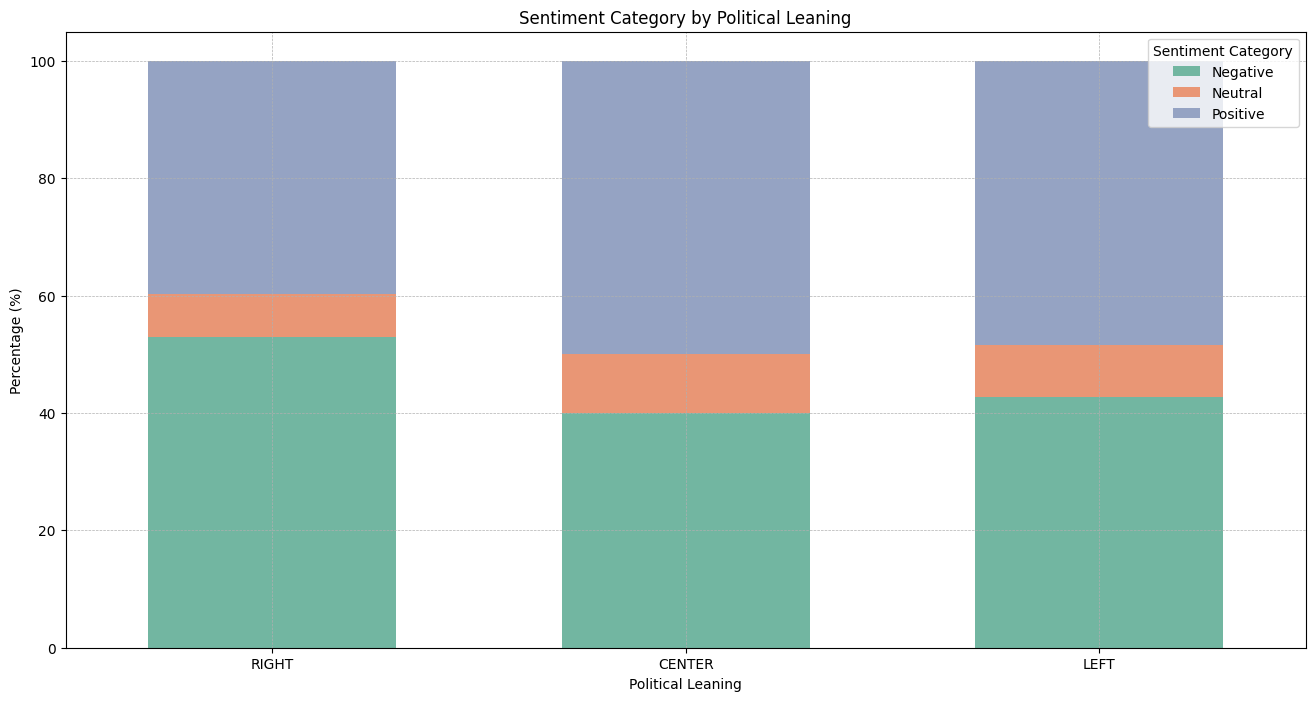

In [38]:
sia = SentimentIntensityAnalyzer()

# Compute sentiment score
polusa_balanced_final["text_sentiment"] = polusa_balanced_final["text_cleaned"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

# Function to categorize sentiment
def categorize_sentiment(score):
    if score <= -0.2:
        return "Negative"
    elif score >= 0.2:
        return "Positive"
    else:
        return "Neutral"

# Apply categorization
polusa_balanced_final["sentiment_category"] = polusa_balanced_final["text_sentiment"].apply(categorize_sentiment)

# Compute sentiment distribution
sentiment_distribution = polusa_balanced_final.groupby(["political_leaning", "sentiment_category"]).size().unstack()
sentiment_distribution = sentiment_distribution.div(sentiment_distribution.sum(axis = 1), axis = 0) * 100
sentiment_palette = {"Negative": set2_colors[0], "Neutral": set2_colors[1], "Positive": set2_colors[2]}

# Create figure
plt.figure(figsize=(16, 8))

categories = ["RIGHT", "CENTER", "LEFT"]
sentiment_distribution = sentiment_distribution.reindex(categories)
bottom_values = None

for sentiment in ["Negative", "Neutral", "Positive"]:
    sns.barplot(x = sentiment_distribution.index, y = sentiment_distribution[sentiment], color = sentiment_palette[sentiment], label = sentiment, width = 0.6, bottom = bottom_values)
    bottom_values = sentiment_distribution[sentiment] if bottom_values is None else bottom_values + sentiment_distribution[sentiment]

plt.legend(title="Sentiment Category")
plt.title("Sentiment Category by Political Leaning")
plt.xlabel("Political Leaning")
plt.ylabel("Percentage (%)")
plt.grid(True, which = "both", ls = "--", linewidth = 0.5)
plt.show()

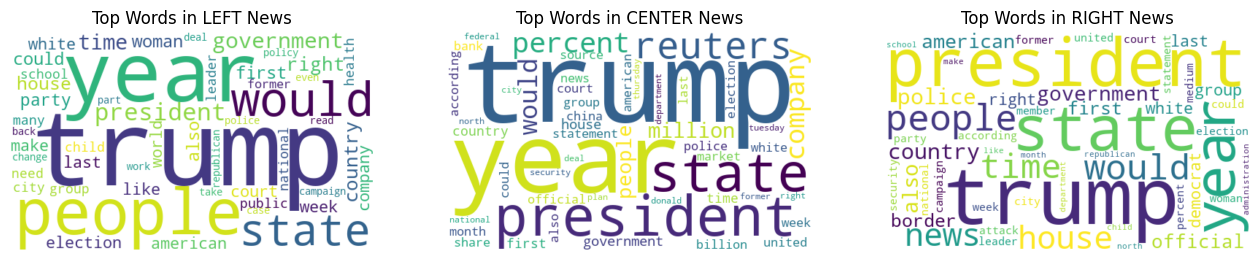

In [45]:
from collections import Counter
from wordcloud import WordCloud

leanings = ["LEFT", "CENTER", "RIGHT"]
excluded_words = {"said", "saying", "told", "says", "say", "report", "reported"}

# Top Words in News by Political Leaning
fig, axes = plt.subplots(1, 3, figsize = (16, 8))
for i, leaning in enumerate(leanings):
    text = " ".join(polusa_balanced_final[polusa_balanced_final["political_leaning"] == leaning]["text_cleaned"])
    filtered_words = [word for word in text.split() if word not in excluded_words]
    word_freq = Counter(filtered_words).most_common(50)    
    wordcloud = WordCloud(width = 500, height = 300, background_color = "white").generate_from_frequencies(dict(word_freq))    
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Top Words in {leaning} News")
plt.show()

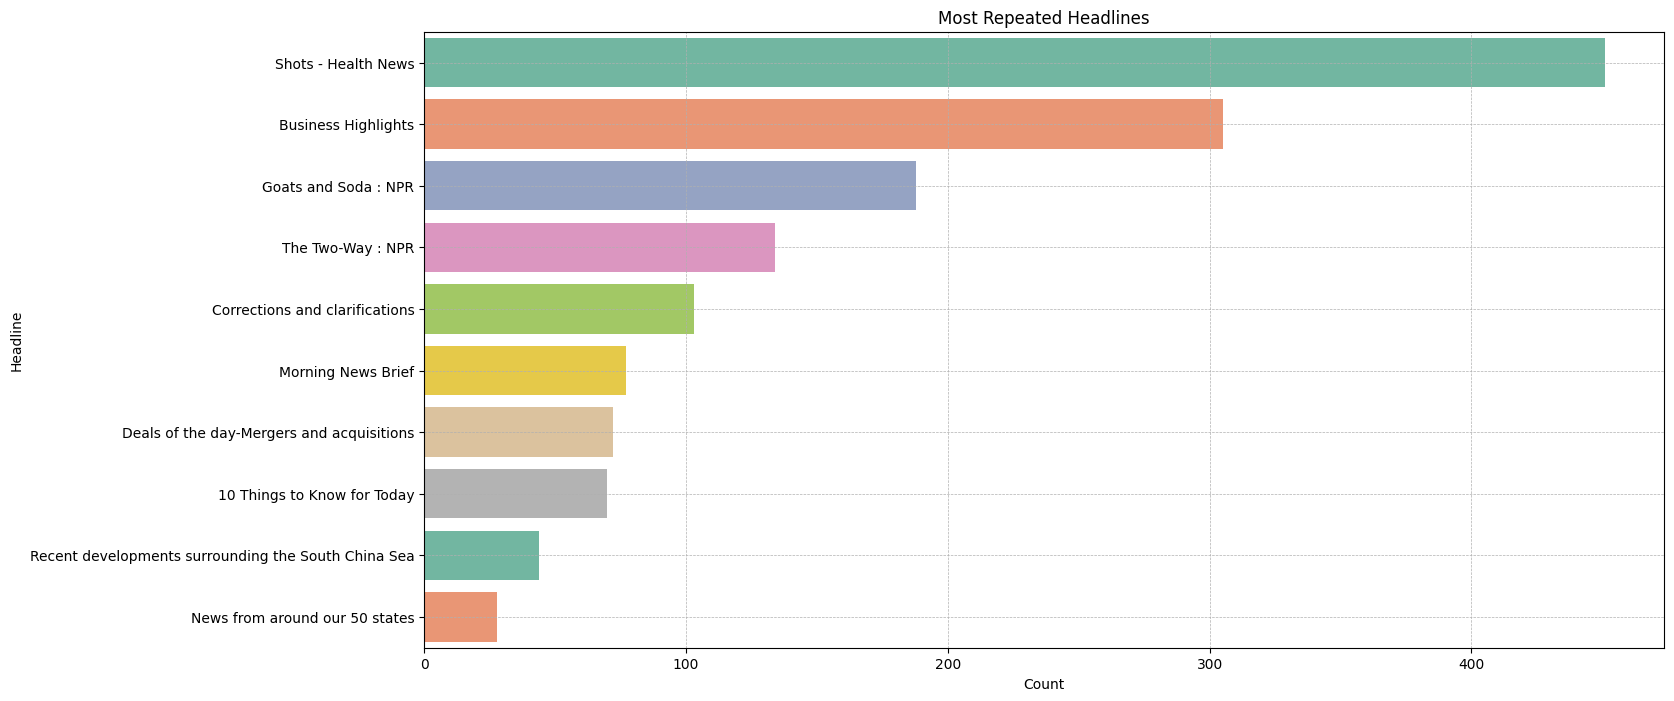

In [40]:
popular_articles = polusa_balanced_final["headline"].value_counts().nlargest(10)

plt.figure(figsize = (16, 8))
sns.barplot(x = popular_articles.values, y = popular_articles.index, hue = popular_articles.index, palette = "Set2")
plt.title("Most Repeated Headlines")
plt.xlabel("Count")
plt.ylabel("Headline")
plt.grid(True, which = "both", ls = "--", linewidth = 0.5)
plt.show()

---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 2. Data Preprocessing </span>

In [ ]:
import pandas as pd

polusa_unbalanced = pd.read_csv('../data/polusa_unbalanced.csv', header = 0)
polusa_balanced = pd.read_csv('../data/polusa_balanced.csv', header = 0)

### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 2.2. TF-IDF (Sparse Matrix) </span>
<div style="text-align: justify;">

 - TF-IDF matrices are usually sparse, meaning they contain many zero values, which makes computation faster.
 - Complexity: $O(N^2 · d)$  where d is the number of features (words).
 - For 400,000+ articles: It can take minutes to hours depending on the machine and the TF-IDF matrix sparsity.

Instead of computing all pairwise similarities, we use Nearest Neighbors Search for fast retrieval
</div>

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Convert the cleaned text into a TF-IDF matrix
vectorizer = TfidfVectorizer(max_features = 50_000)  # Limit features to speed up computation
tfidf_matrix = vectorizer.fit_transform(data_balanced['text_cleaned'])

# Fit NearestNeighbors model (LSH Approximate Search)
nn_tfidf = NearestNeighbors(n_neighbors = 5, metric='cosine', algorithm = 'auto', n_jobs = -1)
nn_tfidf.fit(tfidf_matrix)

NearestNeighbors(metric='cosine', n_jobs=-1)

In [ ]:
import pickle

# Save TF-IDF matrix (large, but needed for inference)
with open("../preprocessing_artifacts/tfidf_matrix.pkl", "wb") as f:
    pickle.dump(tfidf_matrix, f)

# Save Nearest Neighbors model
with open("../models/nn_tfidf.pkl", "wb") as f:
    pickle.dump(nn_tfidf, f)

print("TF-IDF and Nearest Neighbors models saved successfully")

TF-IDF and Nearest Neighbors models saved successfully


### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 2.3. SBERT (Dense Embeddings) </span>
<div style="text-align: justify;">

 - SBERT generates dense vectors, which require more memory and computations.
 - Complexity: $O(N^2)$ (because each article is a 384-dimension vector in all-MiniLM-L6-v2).
 - For 400,000+ articles: The similarity matrix would be huge (400,000 × 400,000 = 40 billion values), making it impractical to compute in RAM.

Instead of computing cosine similarity for all pairs, we use FAISS (Facebook AI Similarity Search) for fast vector search
</div>

In [4]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
import torch

torch.set_default_device("mps")

sbert_model = SentenceTransformer('all-MiniLM-L6-v2', device = "mps")
def encode_in_batches(texts, model, batch_size = 20000):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        batch_embeddings = model.encode(batch, convert_to_numpy=True)
        embeddings.append(batch_embeddings)
        print(f"Processed {i + len(batch)}/{len(texts)} articles")
    return np.vstack(embeddings)

sbert_embeddings = encode_in_batches(data_balanced['text_cleaned'].tolist(), sbert_model, batch_size = 20000)
sbert_embeddings = sbert_embeddings.astype('float32')

faiss.normalize_L2(sbert_embeddings)

# Create FAISS Index
dimension = sbert_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(sbert_embeddings)

Processed 20000/444111 articles
Processed 40000/444111 articles
Processed 60000/444111 articles
Processed 80000/444111 articles
Processed 100000/444111 articles
Processed 120000/444111 articles
Processed 140000/444111 articles
Processed 160000/444111 articles
Processed 180000/444111 articles
Processed 200000/444111 articles
Processed 220000/444111 articles
Processed 240000/444111 articles
Processed 260000/444111 articles
Processed 280000/444111 articles
Processed 300000/444111 articles
Processed 320000/444111 articles
Processed 340000/444111 articles
Processed 360000/444111 articles
Processed 380000/444111 articles
Processed 400000/444111 articles
Processed 420000/444111 articles
Processed 440000/444111 articles
Processed 444111/444111 articles


In [ ]:
np.save("../preprocessing_artifacts/sbert_embeddings.npy", sbert_embeddings)
print("SBERT embeddings saved successfully")

faiss.write_index(index, "../preprocessing_artifacts/faiss_index.bin")
print("FAISS index saved successfully")

SBERT embeddings saved successfully
FAISS index saved successfully


## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 3. News Recommender System (NRS)</span>

In [ ]:
import pickle

# Load TF-IDF matrix
with open("../preprocessing_artifacts/tfidf_matrix.pkl", "rb") as f:
    tfidf_matrix = pickle.load(f)

# Load Nearest Neighbors model
with open("../models/nn_tfidf.pkl", "rb") as f:
    nn_tfidf = pickle.load(f)

print("TF-IDF and Nearest Neighbors models loaded successfully")

TF-IDF and Nearest Neighbors models loaded successfully


In [6]:
import numpy as np
import faiss

# Load SBERT embeddings
sbert_embeddings = np.load("../models/sbert_embeddings.npy")

# Load FAISS index
index = faiss.read_index("../models/faiss_index.bin")

print("SBERT embeddings and FAISS index loaded successfully")

SBERT embeddings and FAISS index loaded successfully


In [7]:
import random

def recommend_articles_tfidf_fast(article_id, df, nn_model, tfidf_matrix, top_n = 5):
    idx = df.index[df['id'] == article_id].tolist()[0]
    
    # Query TF-IDF vector
    distances, indices = nn_model.kneighbors(tfidf_matrix[idx])

    # Extract recommendations
    recommended_articles = df.iloc[indices[0][1:]].copy()
    
    # Remove duplicates
    recommended_articles = recommended_articles.drop_duplicates(subset=['headline'])

    # Ensure political diversity
    seen_leanings = set()
    diverse_recommendations = []
    
    for _, row in recommended_articles.iterrows():
        if row['political_leaning'] not in seen_leanings:
            diverse_recommendations.append(row)
            seen_leanings.add(row['political_leaning'])
        if len(diverse_recommendations) >= top_n:
            break
    
    # If we don't have enough, fill randomly
    if len(diverse_recommendations) < top_n:
        remaining_articles = recommended_articles[~recommended_articles['political_leaning'].isin(seen_leanings)]
        diverse_recommendations.extend(random.sample(remaining_articles.to_dict('records'), min(top_n - len(diverse_recommendations), len(remaining_articles))))
    
    return pd.DataFrame(diverse_recommendations)[['id', 'headline', 'political_leaning']]

recommend_articles_tfidf_fast(4587902, data_balanced, nn_tfidf, tfidf_matrix, top_n=5)

,id,headline,political_leaning
84207,4587902,McMaster: FBI indictments prove Russia meddled...,RIGHT
200788,115897612,The Latest: Trump tweet undercuts McMaster Rus...,CENTER


In [8]:
import numpy as np

def recommend_articles_sbert_faiss(article_id, df, index, embeddings, top_n=5):
    idx = df.index[df['id'] == article_id].tolist()[0]
    
    # Query the FAISS index
    query_vector = np.array([embeddings[idx]]).astype('float32')
    faiss.normalize_L2(query_vector)  # Normalize for cosine similarity
    
    distances, indices = index.search(query_vector, top_n + 1)  # +1 to exclude itself
    
    return df.iloc[indices[0][1:]][['id', 'headline', 'political_leaning']]

recommend_articles_sbert_faiss(4587902, data_balanced, index, sbert_embeddings, top_n=5)


,id,headline,political_leaning
84207,4587902,McMaster: FBI indictments prove Russia meddled...,RIGHT
200788,115897612,The Latest: Trump tweet undercuts McMaster Rus...,CENTER
303188,4402867,The Latest: McMaster: Russian meddling beyond ...,RIGHT
44982,4402867,The Latest: McMaster: Russian meddling beyond ...,RIGHT
240241,39075228,Senior Trump adviser says Russian election med...,LEFT


Now we combine TF-IDF (LSH-based) and SBERT (FAISS-based)

In [9]:
def hybrid_recommendations(article_id, df, nn_tfidf, tfidf_matrix, faiss_index, sbert_embeddings, top_n = 5):
    # Get TF-IDF recommendations (Top-3 for relevance)
    tfidf_recommendations = recommend_articles_tfidf_fast(article_id, df, nn_tfidf, tfidf_matrix, top_n = 5)
    
    # Get SBERT recommendations (Top-3 for diversity)
    sbert_recommendations = recommend_articles_sbert_faiss(article_id, df, faiss_index, sbert_embeddings, top_n = 5)

    # Combine results, removing duplicates
    combined_recommendations = pd.concat([tfidf_recommendations, sbert_recommendations]).drop_duplicates(subset=['headline']).head(top_n)

    return combined_recommendations

# Hybrid approach (TF-IDF + SBERT)
hybrid_recommendations(4587902, data_balanced, nn_tfidf, tfidf_matrix, index, sbert_embeddings, top_n = 5)

,id,headline,political_leaning
84207,4587902,McMaster: FBI indictments prove Russia meddled...,RIGHT
200788,115897612,The Latest: Trump tweet undercuts McMaster Rus...,CENTER
303188,4402867,The Latest: McMaster: Russian meddling beyond ...,RIGHT
240241,39075228,Senior Trump adviser says Russian election med...,LEFT


In [10]:
hybrid_recommendations(4509329, data_balanced, nn_tfidf, tfidf_matrix, index, sbert_embeddings, top_n = 5)

,id,headline,political_leaning
4,4509329,Orange County city votes again to opt out of C...,RIGHT
335724,4351819,California City Votes to Defy 'Sanctuary State...,RIGHT
389336,4380843,More California cities looking to reject state...,RIGHT


In [11]:
hybrid_recommendations(113887756, data_balanced, nn_tfidf, tfidf_matrix, index, sbert_embeddings, top_n = 5)

,id,headline,political_leaning
333436,52937377,"After 20 Years, What It Would Take For A Democ...",LEFT
145408,55311421,NBC News: Doug Jones is apparent winner in Ala...,CENTER
285595,55205448,Democrats wrestle with alleged misconduct in t...,CENTER
190453,4318559,'It's Too Expensive:' Alabama Democrat Doug Jo...,RIGHT
36483,1861807,Democrat Jones wins U.S. Senate seat in Alabam...,CENTER


- Make a table to put the first news (the one used for recommending), outlet.
- Also, diverse political leaning.
- Ask if the CBF is correct, it is overspecialized but we want this for the part of personalization.-